In [1]:
import numpy as np

import collections
from pathlib import Path

from astropy.io import fits, votable
from astropy import table
from astropy.utils.data import get_readable_fileobj
from astropy import units as u
from astropy.coordinates import Distance

from specutils import Spectrum1D, SpectralRegion, manipulation, SpectralAxis

from tqdm.autonotebook import tqdm
from multiprocess import Pool

%matplotlib inline
from matplotlib import pyplot as plt

/var/folders/01/gtn_tmm5757drm_2_lrv5q780001l4/T/ipykernel_5246/4068227911.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
datadir = Path('fullgrid')
fitspaths = list(datadir.glob('lte*.fits'))
wavepaths = list(datadir.glob('WAVE*.fits'))
assert len(wavepaths)==1

In [3]:
phoenix_model_waves = fits.getdata(wavepaths[0], 0) * u.angstrom

# Do photometry on the models for the SDSS filters

In [4]:
filter_curves = {}
for filter in 'ugriz':
    with get_readable_fileobj(f'http://classic.sdss.org/dr7/instruments/imager/filters/{filter}.dat', cache=True) as f:
        t = table.Table.read(f.read(), format='ascii')

    tc = t['col1', 'col2']
    tc.rename_columns(['col1', 'col2'], ['wl', 'sens'])
    filter_curves[filter] = tc

In [5]:
ab_source_denom = {}
for filter, ftab in filter_curves.items():
    sax = SpectralAxis(ftab['wl']*u.angstrom)
    dbin = np.diff(sax.bin_edges)
    ab_source_flux = (3631*u.Jy).to(u.erg/u.s/u.cm**2 / u.cm, equivalencies=u.spectral_density(ftab['wl'] * u.angstrom))
    ab_source_denom[filter] = (sax*ab_source_flux*ftab['sens']*dbin).sum()

In [6]:
f = fits.open(fitspaths[1])
fluxunit = u.Unit(f[0].header['BUNIT'])
pspec = Spectrum1D(spectral_axis=phoenix_model_waves, flux=f[0].data * fluxunit, meta=f[0].header)

Lets check assumptions that the units are intended to be treated as spectral flux density at the star's surface.

In [7]:
lhdr = (pspec.meta['PHXLUM'] * u.erg/u.s).to(u.solLum)
lhdr

<Quantity 43.81661442 solLum>

In [8]:
(np.sum(pspec.flux*np.diff(pspec.spectral_axis.bin_edges))*4*np.pi*(pspec.meta['PHXREFF'] * u.cm)**2 ).to(u.solLum)

<Quantity 42.09137363 solLum>

Slightly different, but probably close enough? Might be the lum includes some energy outside the modeled spectrum.

In [9]:
resampler = manipulation.FluxConservingResampler()

distance = 700*u.kpc

fluxes = {}
mags = {}
for filter, ftab in filter_curves.items():
    filter_spec = resampler(pspec, ftab['wl'] * u.angstrom)
    dbin = np.diff(filter_spec.spectral_axis.bin_edges)

    num = (filter_spec.spectral_axis*filter_spec.flux*ftab['sens']*dbin).sum()
    distance_factor = (pspec.meta['PHXREFF'] * u.cm)**2 / distance**2
    fluxes[filter] = distance_factor*num/ab_source_denom[filter]
    mags[filter] = -2.5*np.log10(fluxes[filter].to(u.dimensionless_unscaled).value)

mags

{'u': 27.00838097606949,
 'g': 25.301651637348648,
 'r': 24.714092570511937,
 'i': 24.604658974560433,
 'z': 24.614153092793394}

In [10]:
pspec.meta['PHXTEFF'], mags['g'] - mags['r']

(5900.0, 0.587559066836711)

Pretty reasonable - a bit redder than the Sun (which is ~.45), as it should be.

Now lets do it over everything, but parallel:

In [11]:
distance = 10*u.pc  # absmag

def mfunc(path):
    mags = {}
    with fits.open(path) as f:
        if 'BUNIT' not in f[0].header:
            return None, {'filename': path.name}
        
        fluxunit = u.Unit(f[0].header['BUNIT'])
        pspec = Spectrum1D(spectral_axis=phoenix_model_waves, flux=f[0].data * fluxunit, meta=f[0].header)

        for filter, ftab in filter_curves.items():
            filter_spec = resampler(pspec, ftab['wl'] * u.angstrom)
            dbin = np.diff(filter_spec.spectral_axis.bin_edges)

            num = (filter_spec.wavelength*filter_spec.flux*ftab['sens']*dbin).sum()
            distance_factor = (pspec.meta['PHXREFF'] * u.cm)**2 / distance**2
            flux = distance_factor*num/ab_source_denom[filter]
            mags[filter] = -2.5*np.log10(flux.to(u.dimensionless_unscaled).value)

    meta = dict(f[0].header)
    meta['filename'] = path.name
    return mags, meta

pool = Pool(8)
try:
    results = list(tqdm(pool.imap(mfunc, fitspaths), total=len(fitspaths)))
finally:
    pool.terminate()
    pool.close()

  0%|          | 0/7559 [00:00<?, ?it/s]

In [12]:
metas = [meta for magdict, meta in results if magdict is not None]

mags = collections.defaultdict(list)
for magdict, meta in results:
    if magdict is None:
        print('missing', meta['filename'])
        continue

    for k, v in magdict.items():
        mags[k].append(v)

mags = {filt: np.array(mags) for filt, mags in mags.items()}

missing lte05500-0.00-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte06900-2.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte10800-5.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte06400-1.50-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05400-0.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte10800-4.50-1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte11600-5.50-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte04600-0.00-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte11000-5.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08800-4.00-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte02800-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05000-0.00-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05500-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08600-5.00-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08800-4.50-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte04700-0.00-4.0

In [13]:
distmod = Distance(700*u.kpc).distmod

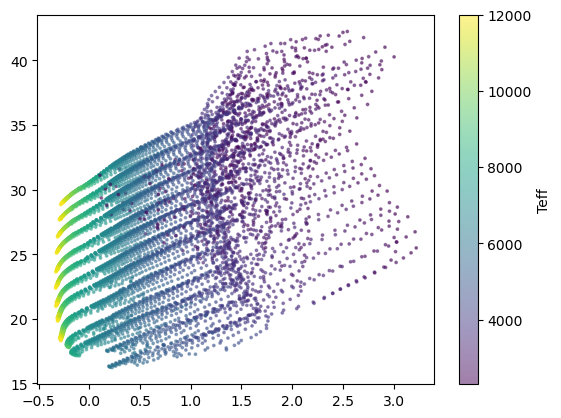

In [14]:
plt.scatter(mags['g'] - mags['r'], mags['r'] + distmod.value, s=3, alpha=.5, c=[m['PHXTEFF'] for m in metas])
plt.colorbar().set_label('Teff')

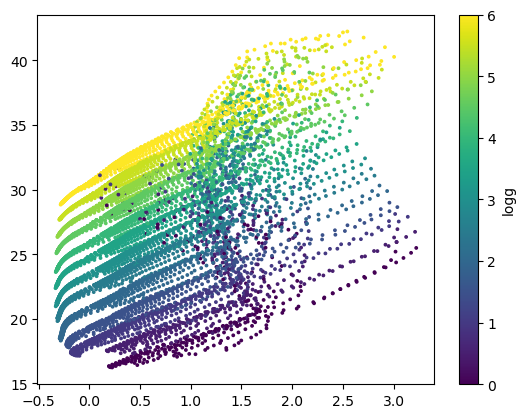

In [15]:
plt.scatter(mags['g'] - mags['r'], mags['r'] + distmod.value, s=3, c=[m['PHXLOGG'] for m in metas])
plt.colorbar().set_label('logg')

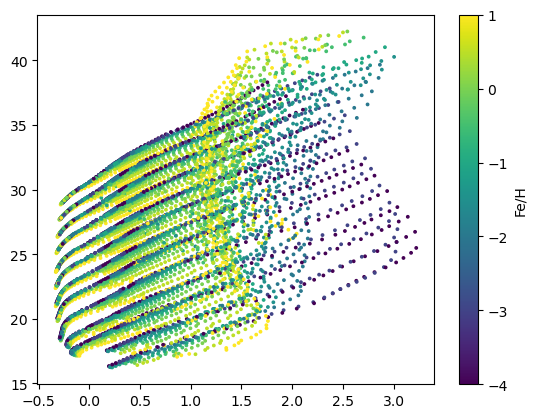

In [16]:
plt.scatter(mags['g'] - mags['r'], mags['r'] + distmod.value, s=3, c=[m['PHXM_H'] for m in metas])
plt.colorbar().set_label('Fe/H')

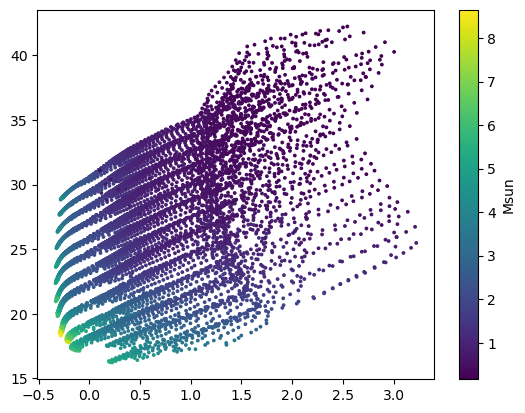

In [17]:
plt.scatter(mags['g'] - mags['r'], mags['r'] + distmod.value, s=3, alpha=1, c=[(m['PHXMASS']*u.g).to(u.solMass).value for m in metas])
plt.colorbar().set_label('Msun')

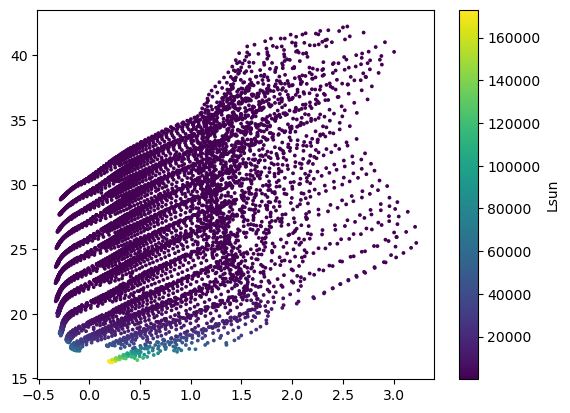

In [18]:
plt.scatter(mags['g'] - mags['r'], mags['r'] + distmod.value, s=3, alpha=1, c=[(m['PHXLUM']*u.erg/u.s).to(u.solLum).value for m in metas])
plt.colorbar().set_label('Lsun')

In [19]:
def color_teff_plot(m1, m2, mags, metas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    sc1 = ax1.scatter(mags[m1] - mags[m2], [m['PHXTEFF'] for m in metas], s=3, c=[m['PHXLOGG'] for m in metas])
    fig.colorbar(sc1).set_label('logg')

    sc2 = ax2.scatter(mags[m1] - mags[m2], [m['PHXTEFF'] for m in metas], s=3, c=[m['PHXM_H'] for m in metas])
    fig.colorbar(sc2).set_label('[M/H]')

    for ax in (ax1, ax2):
        ax.set_xlabel(f'{m1}-{m2}')
        ax.set_ylabel('Teff')
        
    return fig

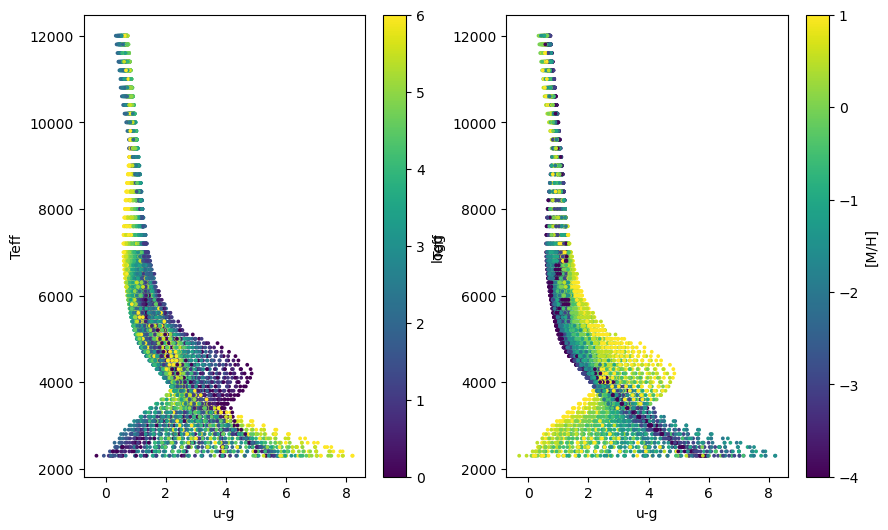

In [20]:
color_teff_plot('u', 'g', mags, metas);

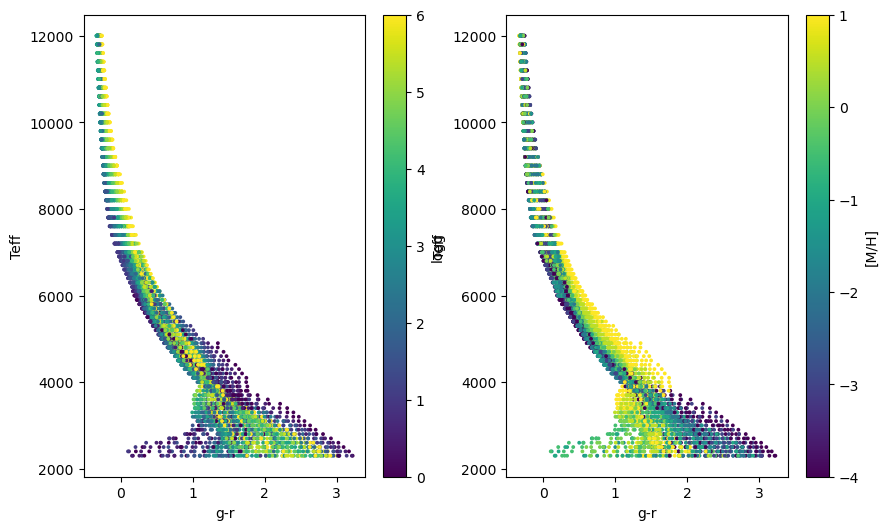

In [21]:
color_teff_plot('g', 'r', mags, metas);

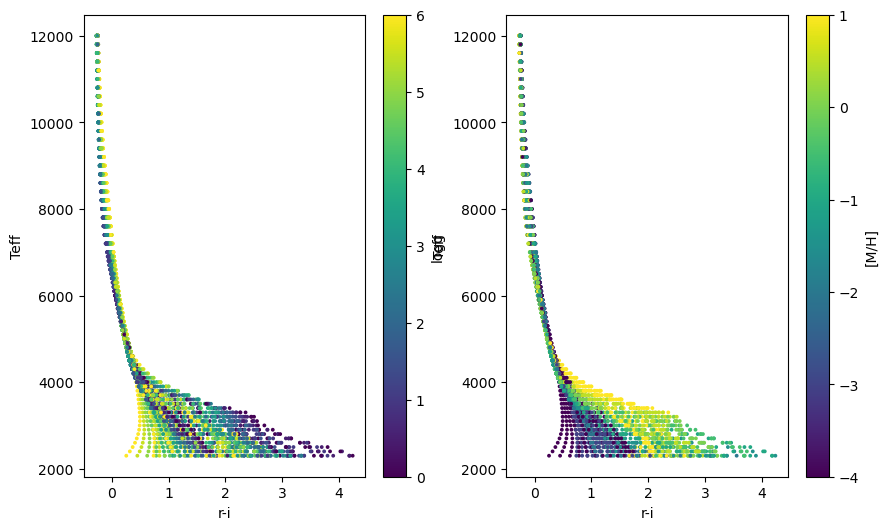

In [22]:
color_teff_plot('r', 'i', mags, metas);

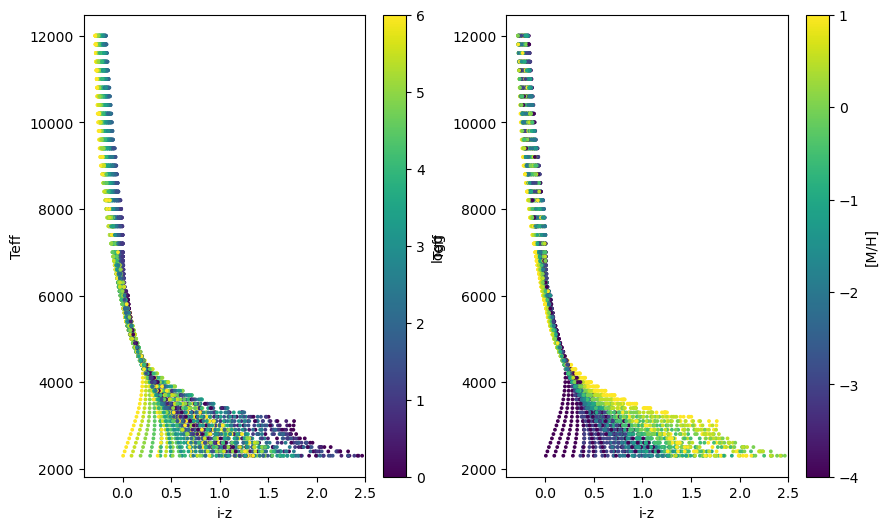

In [23]:
fig = color_teff_plot('i', 'z', mags, metas)

# there's a weird outlier that we supress by manually setting the x-axis
for ax in fig.axes:
    if ax.get_xlabel()=='i-z':
        ax.set_xlim(-.4,2.5)

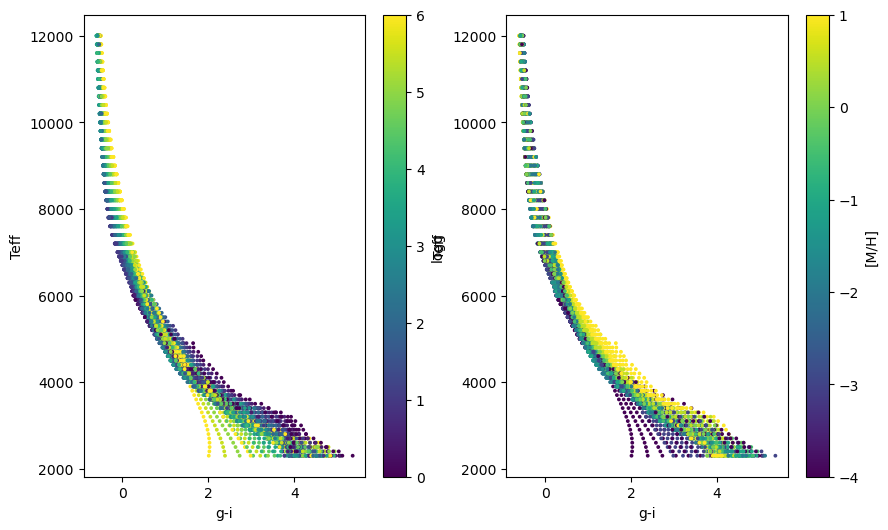

In [24]:
color_teff_plot('g', 'i', mags, metas);

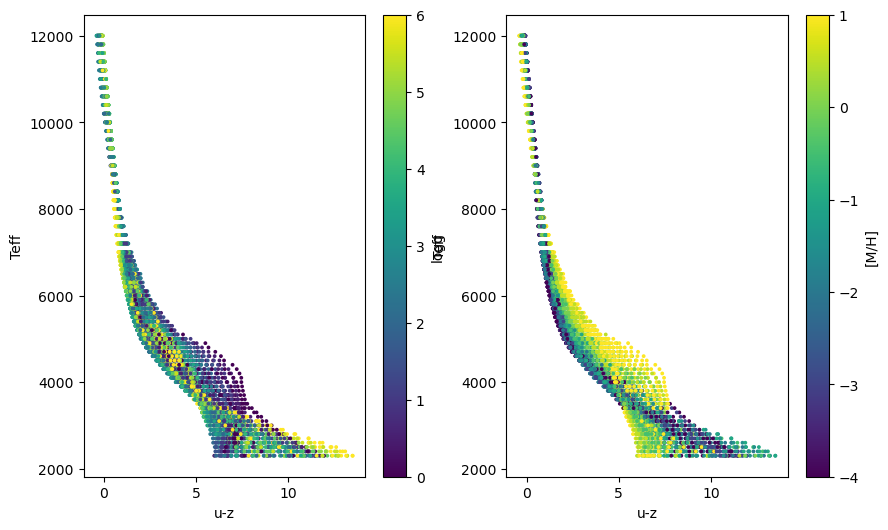

In [25]:
color_teff_plot('u', 'z', mags, metas);

In [26]:
tab = table.Table()
tab['filename'] = [m['filename'] for m in metas]
for k, v in mags.items():
    tab['sdss_' + k + '_AB'] = v

tab['Teff'] = [m['PHXTEFF'] for m in metas]
tab['logg'] = [m['PHXLOGG'] for m in metas]
tab['FeH'] = [m['PHXM_H'] for m in metas]
tab['msun'] = [(m['PHXMASS']*u.g).to(u.solMass).value  for m in metas]
tab['lsun'] = [(m['PHXLUM']*u.erg/u.s).to(u.solLum).value  for m in metas]

tab.write('phoenix_sdss_absmags.ecsv', overwrite=True)

# Do photometry on the models for the Johnson-Cousins filters

Important subtlety: the UBVRI Johnson/Cousins system is an *energy* counting passband description when sourced from SVO, so need to skip the extra lambda when doing the photometry.

In [27]:
jcfilts = 'UBVRI'
cfilts = ('R', 'I')

filter_tables = {}
for filt in jcfilts:
    if filt in cfilts:
        vt = votable.parse(f'http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=Generic/Cousins.{filt}')
    else:
        vt = votable.parse(f'http://svo2.cab.inta-csic.es/theory/fps/fps.php?ID=Generic/Johnson.{filt}')
    filter_tables[filt] = table.QTable(vt.get_first_table().to_table())
    for p in vt.iter_fields_and_params():
        filter_tables[filt].meta[p.ID] = p

In [28]:
vega_source_denom = {}
for filter, ftab in filter_tables.items():
    assert ftab.meta['MagSys'].value == 'Vega'
    zpt = ftab.meta['ZeroPoint'].value * ftab.meta['ZeroPoint'].unit
    
    sax = SpectralAxis(ftab['Wavelength'])
    dbin = np.diff(sax.bin_edges)
    vega_source_flux = zpt.to(u.erg/u.s/u.cm**2 / u.cm, equivalencies=u.spectral_density(ftab['Wavelength']))
    vega_source_denom[filter] = (vega_source_flux*ftab['Transmission']*dbin).sum()  # note the wavelength is removed from this for energy-counter!!

In [29]:
distance = 10*u.pc  # absmag

def mfunc(path):
    mags = {}
    with fits.open(path) as f:
        if 'BUNIT' not in f[0].header:
            return None, {'filename': path.name}
        
        fluxunit = u.Unit(f[0].header['BUNIT'])
        pspec = Spectrum1D(spectral_axis=phoenix_model_waves, flux=f[0].data * fluxunit, meta=f[0].header)

        for filter, ftab in filter_tables.items():
            filter_spec = resampler(pspec, ftab['Wavelength'])
            dbin = np.diff(filter_spec.spectral_axis.bin_edges)

            num = (filter_spec.flux*ftab['Transmission']*dbin).sum()  # note the wavelength is removed from this for energy-counter!!
            distance_factor = (pspec.meta['PHXREFF'] * u.cm)**2 / distance**2
            flux = distance_factor*num/vega_source_denom[filter]
            mags[filter] = -2.5*np.log10(flux.to(u.dimensionless_unscaled).value)

    meta = dict(f[0].header)
    meta['filename'] = path.name
    return mags, meta

pool = Pool(8)
try:
    jcresults = list(tqdm(pool.imap(mfunc, fitspaths), total=len(fitspaths)))
finally:
    pool.terminate()
    pool.close()

  0%|          | 0/7559 [00:00<?, ?it/s]

Why is this so much slower?? Maybe some unit conversion?  Odd.

In [30]:
jcmetas = [meta for magdict, meta in jcresults if magdict is not None]

jcmags = collections.defaultdict(list)
for magdict, meta in jcresults:
    if magdict is None:
        print('missing', meta['filename'])
        continue

    for k, v in magdict.items():
        jcmags[k].append(v)

jcmags = {filt: np.array(mag) for filt, mag in jcmags.items()}

missing lte05500-0.00-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte06900-2.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte10800-5.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte06400-1.50-1.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05400-0.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte10800-4.50-1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte11600-5.50-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte04600-0.00-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte11000-5.50+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08800-4.00-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte02800-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05000-0.00-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte05500-1.00+1.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08600-5.00-3.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte08800-4.50-4.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
missing lte04700-0.00-4.0

In [31]:
tab = table.Table()
tab['filename'] = [m['filename'] for m in jcmetas]
for k, v in jcmags.items():
    jc = 'cousins' if k in cfilts else 'johnson'
    tab[f'{jc}_{k}_vega'] = v

tab['Teff'] = [m['PHXTEFF'] for m in jcmetas]
tab['logg'] = [m['PHXLOGG'] for m in jcmetas]
tab['FeH'] = [m['PHXM_H'] for m in jcmetas]
tab['msun'] = [(m['PHXMASS']*u.g).to(u.solMass).value  for m in jcmetas]
tab['lsun'] = [(m['PHXLUM']*u.erg/u.s).to(u.solLum).value  for m in jcmetas]

tab.write('phoenix_UBVRI_jc_absmags.ecsv', overwrite=True)

(40.0, 15.0)

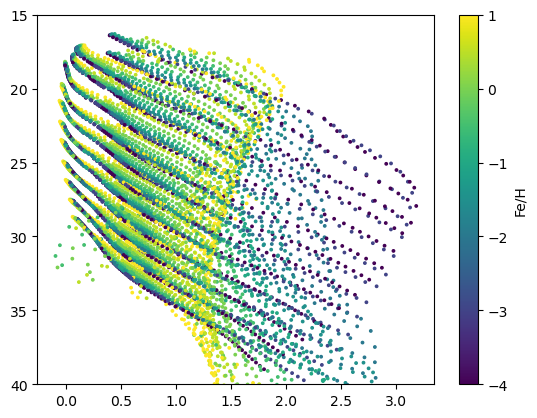

In [32]:
plt.scatter(jcmags['B'] - jcmags['V'], jcmags['V'] + distmod.value, s=3, c=[m['PHXM_H'] for m in jcmetas])
plt.colorbar().set_label('Fe/H')
plt.ylim(40,15)

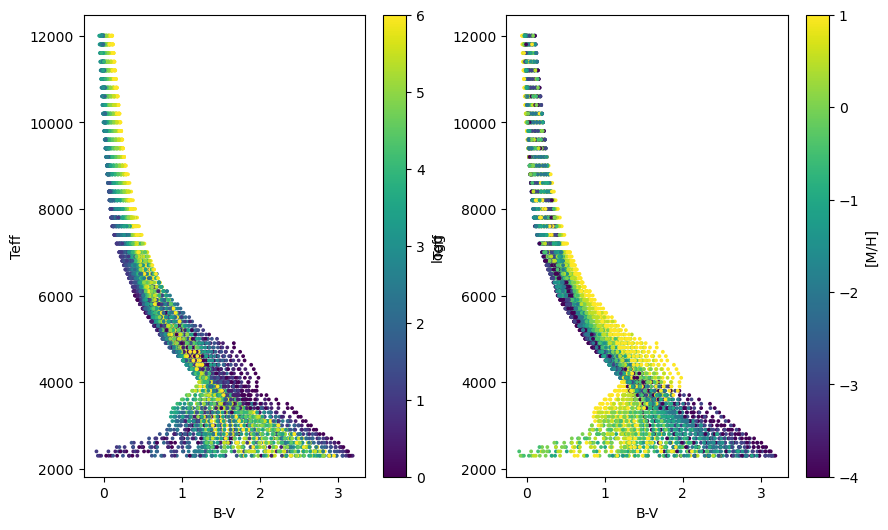

In [33]:
color_teff_plot('B', 'V', jcmags, jcmetas);

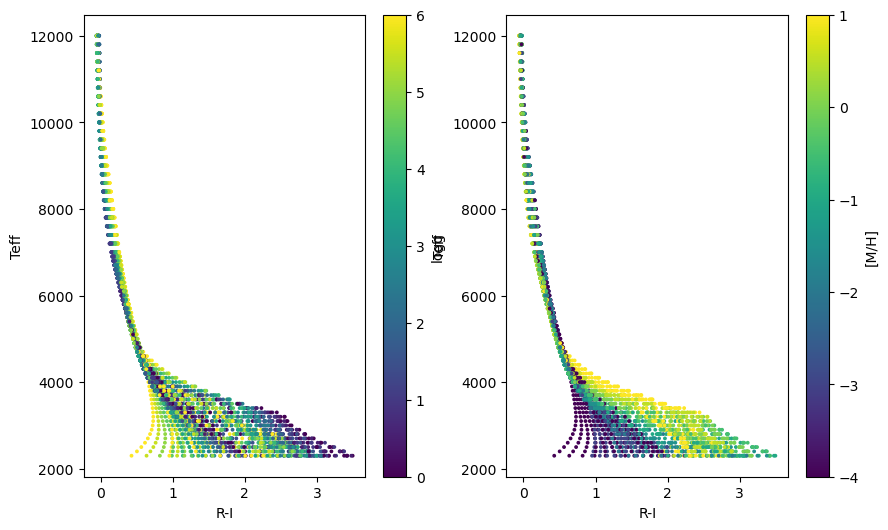

In [34]:
color_teff_plot('R', 'I', jcmags, jcmetas);

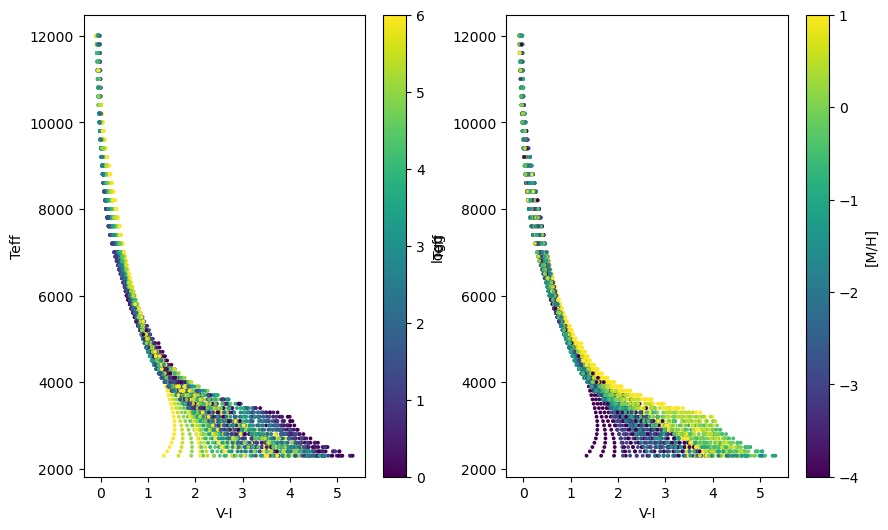

In [35]:
color_teff_plot('V', 'I', jcmags, jcmetas);